In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

In [3]:
# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

In [4]:
# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [5]:
# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in image.list_pictures(list_fams[i], ext='jpg|jpeg|bmp|png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

Processing images ...
Images processed: 9339


In [6]:
os.chdir(cur_dir)

In [7]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [11]:
# Creating base_model (VGG16 convolutional layers)
image_shape = (224, 224, 3)                                                                                                                                               
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False)         

In [12]:
filename = 'virussign-vgg16features.npy'
if os.path.exists(filename):
    print("Loading VGG16 extracted features from %s ..." %(filename))
    vggfeatures = np.load(filename)
else:
    print("Extracting features from VGG16 convolutional layers ...")
    vggfeatures = base_model.predict(X)
    print("Saving VGG16 extracted features into %s ..." %(filename))
    np.save(filename, vggfeatures)

Loading VGG16 extracted features from virussign-vgg16features.npy ...


In [13]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [14]:
# Training top_model and saving min training loss weights
num_epochs=500
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='top_model-weights-min_loss-mlp-vgg16-2layers-160neurons-relu-0.4dropout-Adam-500epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = vggfeatures[train_indices]
    Y_train = Y[train_indices]
    X_test = vggfeatures[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_model = Sequential() 
    top_model.add(Flatten(input_shape=base_model.output_shape[1:])) # input_shape=(7,7,512)                                                
    top_model.add(Dense(160, activation='relu', name='fc1'))
    top_model.add(Dropout(0.4))                
    top_model.add(Dense(160, activation='relu', name='fc2'))
    top_model.add(Dropout(0.4))              
    top_model.add(Dense(num_classes, activation='softmax', name='predictions'))                             
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 8394 samples, validate on 945 samples
Epoch 1/500
8394/8394 [==============================] - 2s - loss: 14.4809 - acc: 0.0193 - val_loss: 6.3668 - val_acc: 0.5418
Epoch 2/500
8394/8394 [==============================] - 1s - loss: 9.4380 - acc: 0.2840 - val_loss: 4.8716 - val_acc: 0.5926
Epoch 3/500
8394/8394 [==============================] - 1s - loss: 6.5650 - acc: 0.5000 - val_loss: 2.5240 - val_acc: 0.8169
Epoch 4/500
8394/8394 [==============================] - 1s - loss: 4.4677 - acc: 0.6371 - val_loss: 2.2481 - val_acc: 0.8233
Epoch 5/500
8394/8394 [==============================] - 1s - loss: 3.5570 - acc: 0.7100 - val_loss: 1.9607 - val_acc: 0.8476
Epoch 6/500
8394/8394 [==============================] - 1s - loss: 2.9573 - acc: 0.7559 - val_loss: 1.4797 - val_acc: 0.8720
Epoch 7/500
8394/8394 [==============================] - 1s - loss: 2.5237 - acc: 0.7850 - val_loss: 1.0772 - val_acc: 0.9069
Epoch 8/500
8394/8394 [==============================] - 1s - loss: 2.

8394/8394 [==============================] - 1s - loss: 0.2020 - acc: 0.9669 - val_loss: 0.1382 - val_acc: 0.9746
Epoch 130/500
8394/8394 [==============================] - 1s - loss: 0.2061 - acc: 0.9647 - val_loss: 0.1467 - val_acc: 0.9725
Epoch 131/500
8394/8394 [==============================] - 1s - loss: 0.2089 - acc: 0.9655 - val_loss: 0.1471 - val_acc: 0.9735
Epoch 132/500
8394/8394 [==============================] - 1s - loss: 0.1983 - acc: 0.9668 - val_loss: 0.1374 - val_acc: 0.9735
Epoch 133/500
8394/8394 [==============================] - 1s - loss: 0.2001 - acc: 0.9662 - val_loss: 0.1317 - val_acc: 0.9735
Epoch 134/500
8394/8394 [==============================] - 1s - loss: 0.2066 - acc: 0.9656 - val_loss: 0.1301 - val_acc: 0.9735
Epoch 135/500
8394/8394 [==============================] - 1s - loss: 0.1981 - acc: 0.9680 - val_loss: 0.1316 - val_acc: 0.9746
Epoch 136/500
8394/8394 [==============================] - 1s - loss: 0.1937 - acc: 0.9688 - val_loss: 0.1314 - val_ac

8394/8394 [==============================] - 1s - loss: 0.1509 - acc: 0.9709 - val_loss: 0.1205 - val_acc: 0.9714
Epoch 258/500
8394/8394 [==============================] - 1s - loss: 0.1613 - acc: 0.9700 - val_loss: 0.1203 - val_acc: 0.9735
Epoch 259/500
8394/8394 [==============================] - 1s - loss: 0.1577 - acc: 0.9702 - val_loss: 0.1204 - val_acc: 0.9735
Epoch 260/500
8394/8394 [==============================] - 1s - loss: 0.1562 - acc: 0.9693 - val_loss: 0.1213 - val_acc: 0.9735
Epoch 261/500
8394/8394 [==============================] - 1s - loss: 0.1580 - acc: 0.9699 - val_loss: 0.1206 - val_acc: 0.9746
Epoch 262/500
8394/8394 [==============================] - 1s - loss: 0.1555 - acc: 0.9693 - val_loss: 0.1187 - val_acc: 0.9746
Epoch 263/500
8394/8394 [==============================] - 1s - loss: 0.1528 - acc: 0.9716 - val_loss: 0.1188 - val_acc: 0.9757
Epoch 264/500
8394/8394 [==============================] - 1s - loss: 0.1505 - acc: 0.9700 - val_loss: 0.1210 - val_ac

8394/8394 [==============================] - 1s - loss: 0.1048 - acc: 0.9745 - val_loss: 0.1161 - val_acc: 0.9767
Epoch 386/500
8394/8394 [==============================] - 1s - loss: 0.1092 - acc: 0.9737 - val_loss: 0.1164 - val_acc: 0.9746
Epoch 387/500
8394/8394 [==============================] - 1s - loss: 0.1074 - acc: 0.9741 - val_loss: 0.1181 - val_acc: 0.9746
Epoch 388/500
8394/8394 [==============================] - 1s - loss: 0.1078 - acc: 0.9744 - val_loss: 0.1204 - val_acc: 0.9757
Epoch 389/500
8394/8394 [==============================] - 1s - loss: 0.1037 - acc: 0.9753 - val_loss: 0.1200 - val_acc: 0.9746
Epoch 390/500
8394/8394 [==============================] - 1s - loss: 0.1066 - acc: 0.9755 - val_loss: 0.1187 - val_acc: 0.9746
Epoch 391/500
8394/8394 [==============================] - 1s - loss: 0.1071 - acc: 0.9744 - val_loss: 0.1197 - val_acc: 0.9735
Epoch 392/500
8394/8394 [==============================] - 1s - loss: 0.1065 - acc: 0.9738 - val_loss: 0.1215 - val_ac

8397/8397 [==============================] - 1s - loss: 2.1815 - acc: 0.8349 - val_loss: 1.5596 - val_acc: 0.9023
Epoch 13/500
8397/8397 [==============================] - 1s - loss: 2.0351 - acc: 0.8434 - val_loss: 1.5497 - val_acc: 0.9023
Epoch 14/500
8397/8397 [==============================] - 1s - loss: 1.9235 - acc: 0.8523 - val_loss: 1.4978 - val_acc: 0.9013
Epoch 15/500
8397/8397 [==============================] - 1s - loss: 1.8279 - acc: 0.8610 - val_loss: 1.3864 - val_acc: 0.9013
Epoch 16/500
8397/8397 [==============================] - 1s - loss: 1.7828 - acc: 0.8632 - val_loss: 1.2691 - val_acc: 0.9055
Epoch 17/500
8397/8397 [==============================] - 1s - loss: 1.6732 - acc: 0.8666 - val_loss: 1.1287 - val_acc: 0.9034
Epoch 18/500
8397/8397 [==============================] - 1s - loss: 1.5371 - acc: 0.8701 - val_loss: 0.9695 - val_acc: 0.9055
Epoch 19/500
8397/8397 [==============================] - 1s - loss: 1.3229 - acc: 0.8747 - val_loss: 0.8636 - val_acc: 0.90

8397/8397 [==============================] - 1s - loss: 0.3601 - acc: 0.9438 - val_loss: 0.2822 - val_acc: 0.9586
Epoch 141/500
8397/8397 [==============================] - 1s - loss: 0.3643 - acc: 0.9425 - val_loss: 0.2819 - val_acc: 0.9586
Epoch 142/500
8397/8397 [==============================] - 1s - loss: 0.3640 - acc: 0.9432 - val_loss: 0.2815 - val_acc: 0.9586
Epoch 143/500
8397/8397 [==============================] - 1s - loss: 0.3594 - acc: 0.9425 - val_loss: 0.2818 - val_acc: 0.9586
Epoch 144/500
8397/8397 [==============================] - 1s - loss: 0.3571 - acc: 0.9434 - val_loss: 0.2827 - val_acc: 0.9586
Epoch 145/500
8397/8397 [==============================] - 1s - loss: 0.3623 - acc: 0.9455 - val_loss: 0.2821 - val_acc: 0.9586
Epoch 146/500
8397/8397 [==============================] - 1s - loss: 0.3502 - acc: 0.9472 - val_loss: 0.2810 - val_acc: 0.9713
Epoch 147/500
8397/8397 [==============================] - 1s - loss: 0.3573 - acc: 0.9427 - val_loss: 0.2804 - val_ac

8397/8397 [==============================] - 1s - loss: 0.3023 - acc: 0.9513 - val_loss: 0.2617 - val_acc: 0.9703
Epoch 269/500
8397/8397 [==============================] - 1s - loss: 0.3129 - acc: 0.9501 - val_loss: 0.2621 - val_acc: 0.9713
Epoch 270/500
8397/8397 [==============================] - 1s - loss: 0.3026 - acc: 0.9518 - val_loss: 0.2623 - val_acc: 0.9713
Epoch 271/500
8397/8397 [==============================] - 1s - loss: 0.3064 - acc: 0.9514 - val_loss: 0.2619 - val_acc: 0.9713
Epoch 272/500
8397/8397 [==============================] - 1s - loss: 0.3110 - acc: 0.9507 - val_loss: 0.2608 - val_acc: 0.9713
Epoch 273/500
8397/8397 [==============================] - 1s - loss: 0.3045 - acc: 0.9520 - val_loss: 0.2614 - val_acc: 0.9713
Epoch 274/500
8397/8397 [==============================] - 1s - loss: 0.2961 - acc: 0.9547 - val_loss: 0.2624 - val_acc: 0.9713
Epoch 275/500
8397/8397 [==============================] - 1s - loss: 0.3069 - acc: 0.9502 - val_loss: 0.2626 - val_ac

8397/8397 [==============================] - 1s - loss: 0.2708 - acc: 0.9562 - val_loss: 0.2491 - val_acc: 0.9692
Epoch 397/500
8397/8397 [==============================] - 1s - loss: 0.2703 - acc: 0.9582 - val_loss: 0.2460 - val_acc: 0.9703
Epoch 398/500
8397/8397 [==============================] - 1s - loss: 0.2661 - acc: 0.9589 - val_loss: 0.2455 - val_acc: 0.9713
Epoch 399/500
8397/8397 [==============================] - 1s - loss: 0.2749 - acc: 0.9543 - val_loss: 0.2464 - val_acc: 0.9703
Epoch 400/500
8397/8397 [==============================] - 1s - loss: 0.2628 - acc: 0.9603 - val_loss: 0.2471 - val_acc: 0.9703
Epoch 401/500
8397/8397 [==============================] - 1s - loss: 0.2680 - acc: 0.9584 - val_loss: 0.2474 - val_acc: 0.9703
Epoch 402/500
8397/8397 [==============================] - 1s - loss: 0.2745 - acc: 0.9559 - val_loss: 0.2463 - val_acc: 0.9703
Epoch 403/500
8397/8397 [==============================] - 1s - loss: 0.2730 - acc: 0.9561 - val_loss: 0.2435 - val_ac

8401/8401 [==============================] - 1s - loss: 0.5852 - acc: 0.8857 - val_loss: 0.4040 - val_acc: 0.9446
Epoch 24/500
8401/8401 [==============================] - 1s - loss: 0.5570 - acc: 0.8866 - val_loss: 0.3887 - val_acc: 0.9488
Epoch 25/500
8401/8401 [==============================] - 1s - loss: 0.5482 - acc: 0.8908 - val_loss: 0.3812 - val_acc: 0.9488
Epoch 26/500
8401/8401 [==============================] - 1s - loss: 0.5512 - acc: 0.8935 - val_loss: 0.3779 - val_acc: 0.9499
Epoch 27/500
8401/8401 [==============================] - 1s - loss: 0.5003 - acc: 0.9035 - val_loss: 0.3651 - val_acc: 0.9542
Epoch 28/500
8401/8401 [==============================] - 1s - loss: 0.4830 - acc: 0.9075 - val_loss: 0.3534 - val_acc: 0.9531
Epoch 29/500
8401/8401 [==============================] - 1s - loss: 0.4810 - acc: 0.9097 - val_loss: 0.3475 - val_acc: 0.9488
Epoch 30/500
8401/8401 [==============================] - 1s - loss: 0.4689 - acc: 0.9123 - val_loss: 0.3434 - val_acc: 0.95

8401/8401 [==============================] - 1s - loss: 0.2680 - acc: 0.9714 - val_loss: 0.3050 - val_acc: 0.9733
Epoch 152/500
8401/8401 [==============================] - 1s - loss: 0.2616 - acc: 0.9742 - val_loss: 0.3022 - val_acc: 0.9733
Epoch 153/500
8401/8401 [==============================] - 1s - loss: 0.2667 - acc: 0.9729 - val_loss: 0.3002 - val_acc: 0.9744
Epoch 154/500
8401/8401 [==============================] - 1s - loss: 0.2592 - acc: 0.9735 - val_loss: 0.2990 - val_acc: 0.9744
Epoch 155/500
8401/8401 [==============================] - 1s - loss: 0.2601 - acc: 0.9744 - val_loss: 0.2974 - val_acc: 0.9755
Epoch 156/500
8401/8401 [==============================] - 1s - loss: 0.2626 - acc: 0.9745 - val_loss: 0.2978 - val_acc: 0.9776
Epoch 157/500
8401/8401 [==============================] - 1s - loss: 0.2639 - acc: 0.9726 - val_loss: 0.2968 - val_acc: 0.9765
Epoch 158/500
8401/8401 [==============================] - 1s - loss: 0.2638 - acc: 0.9735 - val_loss: 0.2967 - val_ac

8401/8401 [==============================] - 1s - loss: 0.2414 - acc: 0.9775 - val_loss: 0.2852 - val_acc: 0.9787
Epoch 280/500
8401/8401 [==============================] - 1s - loss: 0.2378 - acc: 0.9785 - val_loss: 0.2867 - val_acc: 0.9776
Epoch 281/500
8401/8401 [==============================] - 1s - loss: 0.2387 - acc: 0.9779 - val_loss: 0.2890 - val_acc: 0.9755
Epoch 282/500
8401/8401 [==============================] - 1s - loss: 0.2360 - acc: 0.9780 - val_loss: 0.2897 - val_acc: 0.9776
Epoch 283/500
8401/8401 [==============================] - 1s - loss: 0.2382 - acc: 0.9779 - val_loss: 0.2894 - val_acc: 0.9787
Epoch 284/500
8401/8401 [==============================] - 1s - loss: 0.2317 - acc: 0.9805 - val_loss: 0.2895 - val_acc: 0.9776
Epoch 285/500
8401/8401 [==============================] - 1s - loss: 0.2368 - acc: 0.9788 - val_loss: 0.2906 - val_acc: 0.9776
Epoch 286/500
8401/8401 [==============================] - 1s - loss: 0.2413 - acc: 0.9785 - val_loss: 0.2916 - val_ac

8401/8401 [==============================] - 1s - loss: 0.2237 - acc: 0.9801 - val_loss: 0.2880 - val_acc: 0.9755
Epoch 408/500
8401/8401 [==============================] - 1s - loss: 0.2253 - acc: 0.9796 - val_loss: 0.2872 - val_acc: 0.9755
Epoch 409/500
8401/8401 [==============================] - 1s - loss: 0.2241 - acc: 0.9801 - val_loss: 0.2856 - val_acc: 0.9776
Epoch 410/500
8401/8401 [==============================] - 1s - loss: 0.2252 - acc: 0.9795 - val_loss: 0.2856 - val_acc: 0.9765
Epoch 411/500
8401/8401 [==============================] - 1s - loss: 0.2242 - acc: 0.9806 - val_loss: 0.2862 - val_acc: 0.9765
Epoch 412/500
8401/8401 [==============================] - 1s - loss: 0.2252 - acc: 0.9806 - val_loss: 0.2867 - val_acc: 0.9755
Epoch 413/500
8401/8401 [==============================] - 1s - loss: 0.2244 - acc: 0.9805 - val_loss: 0.2872 - val_acc: 0.9765
Epoch 414/500
8401/8401 [==============================] - 1s - loss: 0.2212 - acc: 0.9810 - val_loss: 0.2865 - val_ac

8403/8403 [==============================] - 1s - loss: 0.5375 - acc: 0.8977 - val_loss: 0.4118 - val_acc: 0.9306
Epoch 35/500
8403/8403 [==============================] - 1s - loss: 0.5239 - acc: 0.9003 - val_loss: 0.4098 - val_acc: 0.9306
Epoch 36/500
8403/8403 [==============================] - 1s - loss: 0.5082 - acc: 0.9025 - val_loss: 0.4093 - val_acc: 0.9306
Epoch 37/500
8403/8403 [==============================] - 1s - loss: 0.5009 - acc: 0.9075 - val_loss: 0.4061 - val_acc: 0.9423
Epoch 38/500
8403/8403 [==============================] - 1s - loss: 0.4944 - acc: 0.9099 - val_loss: 0.4028 - val_acc: 0.9423
Epoch 39/500
8403/8403 [==============================] - 1s - loss: 0.4841 - acc: 0.9100 - val_loss: 0.3981 - val_acc: 0.9434
Epoch 40/500
8403/8403 [==============================] - 1s - loss: 0.4781 - acc: 0.9156 - val_loss: 0.3934 - val_acc: 0.9455
Epoch 41/500
8403/8403 [==============================] - 1s - loss: 0.4699 - acc: 0.9148 - val_loss: 0.3879 - val_acc: 0.94

8403/8403 [==============================] - 1s - loss: 0.3241 - acc: 0.9537 - val_loss: 0.2864 - val_acc: 0.9765
Epoch 163/500
8403/8403 [==============================] - 1s - loss: 0.3087 - acc: 0.9579 - val_loss: 0.2830 - val_acc: 0.9754
Epoch 164/500
8403/8403 [==============================] - 1s - loss: 0.3198 - acc: 0.9550 - val_loss: 0.2795 - val_acc: 0.9765
Epoch 165/500
8403/8403 [==============================] - 1s - loss: 0.3190 - acc: 0.9517 - val_loss: 0.2813 - val_acc: 0.9754
Epoch 166/500
8403/8403 [==============================] - 1s - loss: 0.3194 - acc: 0.9534 - val_loss: 0.2847 - val_acc: 0.9754
Epoch 167/500
8403/8403 [==============================] - 1s - loss: 0.3191 - acc: 0.9545 - val_loss: 0.2848 - val_acc: 0.9754
Epoch 168/500
8403/8403 [==============================] - 1s - loss: 0.3209 - acc: 0.9545 - val_loss: 0.2842 - val_acc: 0.9754
Epoch 169/500
8403/8403 [==============================] - 1s - loss: 0.3127 - acc: 0.9572 - val_loss: 0.2818 - val_ac

8403/8403 [==============================] - 1s - loss: 0.2782 - acc: 0.9591 - val_loss: 0.2512 - val_acc: 0.9765
Epoch 291/500
8403/8403 [==============================] - 1s - loss: 0.2794 - acc: 0.9595 - val_loss: 0.2552 - val_acc: 0.9744
Epoch 292/500
8403/8403 [==============================] - 1s - loss: 0.2798 - acc: 0.9610 - val_loss: 0.2541 - val_acc: 0.9744
Epoch 293/500
8403/8403 [==============================] - 1s - loss: 0.2682 - acc: 0.9629 - val_loss: 0.2512 - val_acc: 0.9776
Epoch 294/500
8403/8403 [==============================] - 1s - loss: 0.2867 - acc: 0.9588 - val_loss: 0.2508 - val_acc: 0.9776
Epoch 295/500
8403/8403 [==============================] - 1s - loss: 0.2784 - acc: 0.9606 - val_loss: 0.2512 - val_acc: 0.9765
Epoch 296/500
8403/8403 [==============================] - 1s - loss: 0.2737 - acc: 0.9604 - val_loss: 0.2556 - val_acc: 0.9754
Epoch 297/500
8403/8403 [==============================] - 1s - loss: 0.2787 - acc: 0.9610 - val_loss: 0.2571 - val_ac

8403/8403 [==============================] - 1s - loss: 0.2623 - acc: 0.9626 - val_loss: 0.2451 - val_acc: 0.9776
Epoch 419/500
8403/8403 [==============================] - 1s - loss: 0.2652 - acc: 0.9630 - val_loss: 0.2450 - val_acc: 0.9776
Epoch 420/500
8403/8403 [==============================] - 1s - loss: 0.2634 - acc: 0.9648 - val_loss: 0.2447 - val_acc: 0.9765
Epoch 421/500
8403/8403 [==============================] - 1s - loss: 0.2583 - acc: 0.9666 - val_loss: 0.2444 - val_acc: 0.9776
Epoch 422/500
8403/8403 [==============================] - 1s - loss: 0.2611 - acc: 0.9658 - val_loss: 0.2445 - val_acc: 0.9786
Epoch 423/500
8403/8403 [==============================] - 1s - loss: 0.2643 - acc: 0.9633 - val_loss: 0.2463 - val_acc: 0.9786
Epoch 424/500
8403/8403 [==============================] - 1s - loss: 0.2602 - acc: 0.9642 - val_loss: 0.2478 - val_acc: 0.9776
Epoch 425/500
8403/8403 [==============================] - 1s - loss: 0.2580 - acc: 0.9648 - val_loss: 0.2456 - val_ac

8404/8404 [==============================] - 1s - loss: 0.6335 - acc: 0.9131 - val_loss: 0.5993 - val_acc: 0.9219
Epoch 46/500
8404/8404 [==============================] - 1s - loss: 0.5961 - acc: 0.9133 - val_loss: 0.5624 - val_acc: 0.9251
Epoch 47/500
8404/8404 [==============================] - 1s - loss: 0.5718 - acc: 0.9130 - val_loss: 0.5246 - val_acc: 0.9273
Epoch 48/500
8404/8404 [==============================] - 1s - loss: 0.5372 - acc: 0.9133 - val_loss: 0.4970 - val_acc: 0.9348
Epoch 49/500
8404/8404 [==============================] - 1s - loss: 0.5047 - acc: 0.9156 - val_loss: 0.4725 - val_acc: 0.9348
Epoch 50/500
8404/8404 [==============================] - 1s - loss: 0.4995 - acc: 0.9122 - val_loss: 0.4516 - val_acc: 0.9348
Epoch 51/500
8404/8404 [==============================] - 1s - loss: 0.4943 - acc: 0.9136 - val_loss: 0.4431 - val_acc: 0.9369
Epoch 52/500
8404/8404 [==============================] - 1s - loss: 0.4895 - acc: 0.9136 - val_loss: 0.4386 - val_acc: 0.93

8404/8404 [==============================] - 1s - loss: 0.3352 - acc: 0.9507 - val_loss: 0.3143 - val_acc: 0.9604
Epoch 174/500
8404/8404 [==============================] - 1s - loss: 0.3347 - acc: 0.9501 - val_loss: 0.3121 - val_acc: 0.9604
Epoch 175/500
8404/8404 [==============================] - 1s - loss: 0.3309 - acc: 0.9503 - val_loss: 0.3076 - val_acc: 0.9583
Epoch 176/500
8404/8404 [==============================] - 1s - loss: 0.3384 - acc: 0.9500 - val_loss: 0.3092 - val_acc: 0.9583
Epoch 177/500
8404/8404 [==============================] - 1s - loss: 0.3372 - acc: 0.9491 - val_loss: 0.3119 - val_acc: 0.9551
Epoch 178/500
8404/8404 [==============================] - 1s - loss: 0.3388 - acc: 0.9486 - val_loss: 0.3120 - val_acc: 0.9561
Epoch 179/500
8404/8404 [==============================] - 1s - loss: 0.3388 - acc: 0.9504 - val_loss: 0.3078 - val_acc: 0.9572
Epoch 180/500
8404/8404 [==============================] - 1s - loss: 0.3348 - acc: 0.9499 - val_loss: 0.3034 - val_ac

8404/8404 [==============================] - 1s - loss: 0.2852 - acc: 0.9574 - val_loss: 0.2880 - val_acc: 0.9594
Epoch 302/500
8404/8404 [==============================] - 1s - loss: 0.2869 - acc: 0.9564 - val_loss: 0.2920 - val_acc: 0.9583
Epoch 303/500
8404/8404 [==============================] - 1s - loss: 0.2841 - acc: 0.9594 - val_loss: 0.2900 - val_acc: 0.9615
Epoch 304/500
8404/8404 [==============================] - 1s - loss: 0.2916 - acc: 0.9580 - val_loss: 0.2853 - val_acc: 0.9604
Epoch 305/500
8404/8404 [==============================] - 1s - loss: 0.2854 - acc: 0.9559 - val_loss: 0.2839 - val_acc: 0.9615
Epoch 306/500
8404/8404 [==============================] - 1s - loss: 0.2893 - acc: 0.9559 - val_loss: 0.2864 - val_acc: 0.9594
Epoch 307/500
8404/8404 [==============================] - 1s - loss: 0.2835 - acc: 0.9580 - val_loss: 0.2899 - val_acc: 0.9604
Epoch 308/500
8404/8404 [==============================] - 1s - loss: 0.2973 - acc: 0.9553 - val_loss: 0.2872 - val_ac

8404/8404 [==============================] - 1s - loss: 0.2688 - acc: 0.9609 - val_loss: 0.2839 - val_acc: 0.9594
Epoch 430/500
8404/8404 [==============================] - 1s - loss: 0.2658 - acc: 0.9631 - val_loss: 0.2817 - val_acc: 0.9594
Epoch 431/500
8404/8404 [==============================] - 1s - loss: 0.2692 - acc: 0.9614 - val_loss: 0.2823 - val_acc: 0.9583
Epoch 432/500
8404/8404 [==============================] - 1s - loss: 0.2680 - acc: 0.9611 - val_loss: 0.2853 - val_acc: 0.9583
Epoch 433/500
8404/8404 [==============================] - 1s - loss: 0.2689 - acc: 0.9604 - val_loss: 0.2921 - val_acc: 0.9594
Epoch 434/500
8404/8404 [==============================] - 1s - loss: 0.2712 - acc: 0.9600 - val_loss: 0.3000 - val_acc: 0.9594
Epoch 435/500
8404/8404 [==============================] - 1s - loss: 0.2659 - acc: 0.9637 - val_loss: 0.3029 - val_acc: 0.9594
Epoch 436/500
8404/8404 [==============================] - 1s - loss: 0.2653 - acc: 0.9610 - val_loss: 0.3000 - val_ac

8404/8404 [==============================] - 1s - loss: 0.3854 - acc: 0.9343 - val_loss: 0.3274 - val_acc: 0.9508
Epoch 58/500
8404/8404 [==============================] - 1s - loss: 0.3865 - acc: 0.9360 - val_loss: 0.3261 - val_acc: 0.9508
Epoch 59/500
8404/8404 [==============================] - 1s - loss: 0.3832 - acc: 0.9382 - val_loss: 0.3242 - val_acc: 0.9508
Epoch 60/500
8404/8404 [==============================] - 1s - loss: 0.3843 - acc: 0.9348 - val_loss: 0.3236 - val_acc: 0.9508
Epoch 61/500
8404/8404 [==============================] - 1s - loss: 0.3846 - acc: 0.9357 - val_loss: 0.3249 - val_acc: 0.9529
Epoch 62/500
8404/8404 [==============================] - 1s - loss: 0.3798 - acc: 0.9357 - val_loss: 0.3268 - val_acc: 0.9540
Epoch 63/500
8404/8404 [==============================] - 1s - loss: 0.3777 - acc: 0.9388 - val_loss: 0.3169 - val_acc: 0.9519
Epoch 64/500
8404/8404 [==============================] - 1s - loss: 0.3630 - acc: 0.9409 - val_loss: 0.3078 - val_acc: 0.95

8404/8404 [==============================] - 1s - loss: 0.2724 - acc: 0.9624 - val_loss: 0.2416 - val_acc: 0.9754
Epoch 186/500
8404/8404 [==============================] - 1s - loss: 0.2692 - acc: 0.9613 - val_loss: 0.2394 - val_acc: 0.9765
Epoch 187/500
8404/8404 [==============================] - 1s - loss: 0.2713 - acc: 0.9609 - val_loss: 0.2357 - val_acc: 0.9775
Epoch 188/500
8404/8404 [==============================] - 1s - loss: 0.2690 - acc: 0.9614 - val_loss: 0.2344 - val_acc: 0.9775
Epoch 189/500
8404/8404 [==============================] - 1s - loss: 0.2627 - acc: 0.9619 - val_loss: 0.2348 - val_acc: 0.9765
Epoch 190/500
8404/8404 [==============================] - 1s - loss: 0.2680 - acc: 0.9610 - val_loss: 0.2374 - val_acc: 0.9765
Epoch 191/500
8404/8404 [==============================] - 1s - loss: 0.2588 - acc: 0.9638 - val_loss: 0.2399 - val_acc: 0.9765
Epoch 192/500
8404/8404 [==============================] - 1s - loss: 0.2651 - acc: 0.9638 - val_loss: 0.2410 - val_ac

8404/8404 [==============================] - 1s - loss: 0.2289 - acc: 0.9739 - val_loss: 0.2422 - val_acc: 0.9775
Epoch 314/500
8404/8404 [==============================] - 1s - loss: 0.2328 - acc: 0.9736 - val_loss: 0.2416 - val_acc: 0.9775
Epoch 315/500
8404/8404 [==============================] - 1s - loss: 0.2316 - acc: 0.9739 - val_loss: 0.2413 - val_acc: 0.9765
Epoch 316/500
8404/8404 [==============================] - 1s - loss: 0.2170 - acc: 0.9774 - val_loss: 0.2415 - val_acc: 0.9765
Epoch 317/500
8404/8404 [==============================] - 1s - loss: 0.2264 - acc: 0.9748 - val_loss: 0.2421 - val_acc: 0.9765
Epoch 318/500
8404/8404 [==============================] - 1s - loss: 0.2192 - acc: 0.9766 - val_loss: 0.2428 - val_acc: 0.9765
Epoch 319/500
8404/8404 [==============================] - 1s - loss: 0.2233 - acc: 0.9758 - val_loss: 0.2434 - val_acc: 0.9775
Epoch 320/500
8404/8404 [==============================] - 1s - loss: 0.2258 - acc: 0.9754 - val_loss: 0.2442 - val_ac

8404/8404 [==============================] - 1s - loss: 0.2229 - acc: 0.9767 - val_loss: 0.2593 - val_acc: 0.9754
Epoch 442/500
8404/8404 [==============================] - 1s - loss: 0.2184 - acc: 0.9766 - val_loss: 0.2610 - val_acc: 0.9754
Epoch 443/500
8404/8404 [==============================] - 1s - loss: 0.2136 - acc: 0.9798 - val_loss: 0.2626 - val_acc: 0.9754
Epoch 444/500
8404/8404 [==============================] - 1s - loss: 0.2145 - acc: 0.9786 - val_loss: 0.2639 - val_acc: 0.9765
Epoch 445/500
8404/8404 [==============================] - 1s - loss: 0.2156 - acc: 0.9776 - val_loss: 0.2620 - val_acc: 0.9765
Epoch 446/500
8404/8404 [==============================] - 1s - loss: 0.2235 - acc: 0.9750 - val_loss: 0.2593 - val_acc: 0.9754
Epoch 447/500
8404/8404 [==============================] - 1s - loss: 0.2230 - acc: 0.9767 - val_loss: 0.2568 - val_acc: 0.9765
Epoch 448/500
8404/8404 [==============================] - 1s - loss: 0.2167 - acc: 0.9802 - val_loss: 0.2534 - val_ac

8408/8408 [==============================] - 1s - loss: 0.3012 - acc: 0.9610 - val_loss: 0.2846 - val_acc: 0.9699
Epoch 69/500
8408/8408 [==============================] - 1s - loss: 0.3022 - acc: 0.9629 - val_loss: 0.2862 - val_acc: 0.9699
Epoch 70/500
8408/8408 [==============================] - 1s - loss: 0.3142 - acc: 0.9611 - val_loss: 0.2851 - val_acc: 0.9710
Epoch 71/500
8408/8408 [==============================] - 1s - loss: 0.3020 - acc: 0.9624 - val_loss: 0.2844 - val_acc: 0.9710
Epoch 72/500
8408/8408 [==============================] - 1s - loss: 0.2926 - acc: 0.9650 - val_loss: 0.2846 - val_acc: 0.9721
Epoch 73/500
8408/8408 [==============================] - 1s - loss: 0.2889 - acc: 0.9657 - val_loss: 0.2831 - val_acc: 0.9710
Epoch 74/500
8408/8408 [==============================] - 1s - loss: 0.2946 - acc: 0.9641 - val_loss: 0.2813 - val_acc: 0.9710
Epoch 75/500
8408/8408 [==============================] - 1s - loss: 0.2975 - acc: 0.9630 - val_loss: 0.2835 - val_acc: 0.97

8408/8408 [==============================] - 1s - loss: 0.2506 - acc: 0.9761 - val_loss: 0.2961 - val_acc: 0.9731
Epoch 197/500
8408/8408 [==============================] - 1s - loss: 0.2495 - acc: 0.9774 - val_loss: 0.2932 - val_acc: 0.9731
Epoch 198/500
8408/8408 [==============================] - 1s - loss: 0.2476 - acc: 0.9768 - val_loss: 0.2900 - val_acc: 0.9731
Epoch 199/500
8408/8408 [==============================] - 1s - loss: 0.2616 - acc: 0.9748 - val_loss: 0.2889 - val_acc: 0.9731
Epoch 200/500
8408/8408 [==============================] - 1s - loss: 0.2466 - acc: 0.9765 - val_loss: 0.2905 - val_acc: 0.9721
Epoch 201/500
8408/8408 [==============================] - 1s - loss: 0.2529 - acc: 0.9767 - val_loss: 0.2919 - val_acc: 0.9721
Epoch 202/500
8408/8408 [==============================] - 1s - loss: 0.2488 - acc: 0.9769 - val_loss: 0.2933 - val_acc: 0.9721
Epoch 203/500
8408/8408 [==============================] - 1s - loss: 0.2444 - acc: 0.9776 - val_loss: 0.2954 - val_ac

8408/8408 [==============================] - 1s - loss: 0.2284 - acc: 0.9793 - val_loss: 0.2898 - val_acc: 0.9710
Epoch 325/500
8408/8408 [==============================] - 1s - loss: 0.2253 - acc: 0.9801 - val_loss: 0.2856 - val_acc: 0.9710
Epoch 326/500
8408/8408 [==============================] - 1s - loss: 0.2286 - acc: 0.9798 - val_loss: 0.2840 - val_acc: 0.9710
Epoch 327/500
8408/8408 [==============================] - 1s - loss: 0.2284 - acc: 0.9788 - val_loss: 0.2848 - val_acc: 0.9710
Epoch 328/500
8408/8408 [==============================] - 1s - loss: 0.2240 - acc: 0.9801 - val_loss: 0.2868 - val_acc: 0.9710
Epoch 329/500
8408/8408 [==============================] - 1s - loss: 0.2244 - acc: 0.9809 - val_loss: 0.2912 - val_acc: 0.9710
Epoch 330/500
8408/8408 [==============================] - 1s - loss: 0.2251 - acc: 0.9804 - val_loss: 0.2930 - val_acc: 0.9710
Epoch 331/500
8408/8408 [==============================] - 1s - loss: 0.2227 - acc: 0.9814 - val_loss: 0.2955 - val_ac

8408/8408 [==============================] - 1s - loss: 0.2104 - acc: 0.9822 - val_loss: 0.2846 - val_acc: 0.9753
Epoch 453/500
8408/8408 [==============================] - 1s - loss: 0.2169 - acc: 0.9814 - val_loss: 0.2873 - val_acc: 0.9753
Epoch 454/500
8408/8408 [==============================] - 1s - loss: 0.2120 - acc: 0.9824 - val_loss: 0.2867 - val_acc: 0.9742
Epoch 455/500
8408/8408 [==============================] - 1s - loss: 0.2144 - acc: 0.9822 - val_loss: 0.2837 - val_acc: 0.9753
Epoch 456/500
8408/8408 [==============================] - 1s - loss: 0.2142 - acc: 0.9823 - val_loss: 0.2799 - val_acc: 0.9742
Epoch 457/500
8408/8408 [==============================] - 1s - loss: 0.2194 - acc: 0.9799 - val_loss: 0.2762 - val_acc: 0.9742
Epoch 458/500
8408/8408 [==============================] - 1s - loss: 0.2224 - acc: 0.9804 - val_loss: 0.2733 - val_acc: 0.9742
Epoch 459/500
8408/8408 [==============================] - 1s - loss: 0.2170 - acc: 0.9820 - val_loss: 0.2708 - val_ac

8410/8410 [==============================] - 1s - loss: 0.3116 - acc: 0.9559 - val_loss: 0.2377 - val_acc: 0.9731
Epoch 80/500
8410/8410 [==============================] - 1s - loss: 0.3069 - acc: 0.9581 - val_loss: 0.2362 - val_acc: 0.9742
Epoch 81/500
8410/8410 [==============================] - 1s - loss: 0.3129 - acc: 0.9570 - val_loss: 0.2401 - val_acc: 0.9742
Epoch 82/500
8410/8410 [==============================] - 1s - loss: 0.2990 - acc: 0.9614 - val_loss: 0.2502 - val_acc: 0.9742
Epoch 83/500
8410/8410 [==============================] - 1s - loss: 0.3006 - acc: 0.9599 - val_loss: 0.2638 - val_acc: 0.9742
Epoch 84/500
8410/8410 [==============================] - 1s - loss: 0.3013 - acc: 0.9595 - val_loss: 0.2518 - val_acc: 0.9763
Epoch 85/500
8410/8410 [==============================] - 1s - loss: 0.2874 - acc: 0.9623 - val_loss: 0.2369 - val_acc: 0.9731
Epoch 86/500
8410/8410 [==============================] - 1s - loss: 0.2942 - acc: 0.9618 - val_loss: 0.2342 - val_acc: 0.97

8410/8410 [==============================] - 1s - loss: 0.2454 - acc: 0.9732 - val_loss: 0.2158 - val_acc: 0.9795
Epoch 208/500
8410/8410 [==============================] - 1s - loss: 0.2533 - acc: 0.9730 - val_loss: 0.2144 - val_acc: 0.9795
Epoch 209/500
8410/8410 [==============================] - 1s - loss: 0.2576 - acc: 0.9728 - val_loss: 0.2155 - val_acc: 0.9795
Epoch 210/500
8410/8410 [==============================] - 1s - loss: 0.2469 - acc: 0.9725 - val_loss: 0.2224 - val_acc: 0.9795
Epoch 211/500
8410/8410 [==============================] - 1s - loss: 0.2557 - acc: 0.9721 - val_loss: 0.2241 - val_acc: 0.9795
Epoch 212/500
8410/8410 [==============================] - 1s - loss: 0.2490 - acc: 0.9717 - val_loss: 0.2239 - val_acc: 0.9785
Epoch 213/500
8410/8410 [==============================] - 1s - loss: 0.2498 - acc: 0.9736 - val_loss: 0.2269 - val_acc: 0.9774
Epoch 214/500
8410/8410 [==============================] - 1s - loss: 0.2444 - acc: 0.9740 - val_loss: 0.2315 - val_ac

8410/8410 [==============================] - 1s - loss: 0.2369 - acc: 0.9757 - val_loss: 0.2409 - val_acc: 0.9785
Epoch 336/500
8410/8410 [==============================] - 1s - loss: 0.2396 - acc: 0.9750 - val_loss: 0.2414 - val_acc: 0.9795
Epoch 337/500
8410/8410 [==============================] - 1s - loss: 0.2286 - acc: 0.9776 - val_loss: 0.2406 - val_acc: 0.9806
Epoch 338/500
8410/8410 [==============================] - 1s - loss: 0.2374 - acc: 0.9767 - val_loss: 0.2390 - val_acc: 0.9806
Epoch 339/500
8410/8410 [==============================] - 1s - loss: 0.2280 - acc: 0.9786 - val_loss: 0.2371 - val_acc: 0.9795
Epoch 340/500
8410/8410 [==============================] - 1s - loss: 0.2329 - acc: 0.9763 - val_loss: 0.2349 - val_acc: 0.9795
Epoch 341/500
8410/8410 [==============================] - 1s - loss: 0.2312 - acc: 0.9788 - val_loss: 0.2363 - val_acc: 0.9785
Epoch 342/500
8410/8410 [==============================] - 1s - loss: 0.2350 - acc: 0.9773 - val_loss: 0.2387 - val_ac

8410/8410 [==============================] - 1s - loss: 0.2168 - acc: 0.9813 - val_loss: 0.2317 - val_acc: 0.9817
Epoch 464/500
8410/8410 [==============================] - 1s - loss: 0.2186 - acc: 0.9804 - val_loss: 0.2341 - val_acc: 0.9817
Epoch 465/500
8410/8410 [==============================] - 1s - loss: 0.2203 - acc: 0.9790 - val_loss: 0.2328 - val_acc: 0.9817
Epoch 466/500
8410/8410 [==============================] - 1s - loss: 0.2225 - acc: 0.9799 - val_loss: 0.2321 - val_acc: 0.9806
Epoch 467/500
8410/8410 [==============================] - 1s - loss: 0.2247 - acc: 0.9793 - val_loss: 0.2316 - val_acc: 0.9806
Epoch 468/500
8410/8410 [==============================] - 1s - loss: 0.2250 - acc: 0.9791 - val_loss: 0.2310 - val_acc: 0.9806
Epoch 469/500
8410/8410 [==============================] - 1s - loss: 0.2197 - acc: 0.9801 - val_loss: 0.2305 - val_acc: 0.9806
Epoch 470/500
8410/8410 [==============================] - 1s - loss: 0.2226 - acc: 0.9787 - val_loss: 0.2310 - val_ac

8414/8414 [==============================] - 1s - loss: 0.2734 - acc: 0.9664 - val_loss: 0.2590 - val_acc: 0.9762
Epoch 91/500
8414/8414 [==============================] - 1s - loss: 0.2755 - acc: 0.9633 - val_loss: 0.2603 - val_acc: 0.9741
Epoch 92/500
8414/8414 [==============================] - 1s - loss: 0.2583 - acc: 0.9695 - val_loss: 0.2596 - val_acc: 0.9741
Epoch 93/500
8414/8414 [==============================] - 1s - loss: 0.2654 - acc: 0.9661 - val_loss: 0.2568 - val_acc: 0.9741
Epoch 94/500
8414/8414 [==============================] - 1s - loss: 0.2802 - acc: 0.9665 - val_loss: 0.2530 - val_acc: 0.9751
Epoch 95/500
8414/8414 [==============================] - 1s - loss: 0.2646 - acc: 0.9672 - val_loss: 0.2511 - val_acc: 0.9741
Epoch 96/500
8414/8414 [==============================] - 1s - loss: 0.2778 - acc: 0.9648 - val_loss: 0.2519 - val_acc: 0.9741
Epoch 97/500
8414/8414 [==============================] - 1s - loss: 0.2690 - acc: 0.9667 - val_loss: 0.2527 - val_acc: 0.97

8414/8414 [==============================] - 1s - loss: 0.2224 - acc: 0.9777 - val_loss: 0.2672 - val_acc: 0.9762
Epoch 219/500
8414/8414 [==============================] - 1s - loss: 0.2222 - acc: 0.9771 - val_loss: 0.2639 - val_acc: 0.9773
Epoch 220/500
8414/8414 [==============================] - 1s - loss: 0.2170 - acc: 0.9787 - val_loss: 0.2605 - val_acc: 0.9751
Epoch 221/500
8414/8414 [==============================] - 1s - loss: 0.2226 - acc: 0.9768 - val_loss: 0.2626 - val_acc: 0.9730
Epoch 222/500
8414/8414 [==============================] - 1s - loss: 0.2185 - acc: 0.9778 - val_loss: 0.2672 - val_acc: 0.9741
Epoch 223/500
8414/8414 [==============================] - 1s - loss: 0.2259 - acc: 0.9773 - val_loss: 0.2691 - val_acc: 0.9741
Epoch 224/500
8414/8414 [==============================] - 1s - loss: 0.2197 - acc: 0.9786 - val_loss: 0.2713 - val_acc: 0.9773
Epoch 225/500
8414/8414 [==============================] - 1s - loss: 0.2236 - acc: 0.9775 - val_loss: 0.2732 - val_ac

8414/8414 [==============================] - 1s - loss: 0.2076 - acc: 0.9824 - val_loss: 0.2743 - val_acc: 0.9751
Epoch 347/500
8414/8414 [==============================] - 1s - loss: 0.2067 - acc: 0.9813 - val_loss: 0.2724 - val_acc: 0.9751
Epoch 348/500
8414/8414 [==============================] - 1s - loss: 0.2075 - acc: 0.9817 - val_loss: 0.2698 - val_acc: 0.9751
Epoch 349/500
8414/8414 [==============================] - 1s - loss: 0.2133 - acc: 0.9803 - val_loss: 0.2649 - val_acc: 0.9762
Epoch 350/500
8414/8414 [==============================] - 1s - loss: 0.2098 - acc: 0.9806 - val_loss: 0.2632 - val_acc: 0.9773
Epoch 351/500
8414/8414 [==============================] - 1s - loss: 0.2084 - acc: 0.9803 - val_loss: 0.2627 - val_acc: 0.9773
Epoch 352/500
8414/8414 [==============================] - 1s - loss: 0.2083 - acc: 0.9815 - val_loss: 0.2621 - val_acc: 0.9762
Epoch 353/500
8414/8414 [==============================] - 1s - loss: 0.2118 - acc: 0.9818 - val_loss: 0.2617 - val_ac

8414/8414 [==============================] - 1s - loss: 0.2079 - acc: 0.9805 - val_loss: 0.2524 - val_acc: 0.9795
Epoch 475/500
8414/8414 [==============================] - 1s - loss: 0.2112 - acc: 0.9805 - val_loss: 0.2498 - val_acc: 0.9795
Epoch 476/500
8414/8414 [==============================] - 1s - loss: 0.2105 - acc: 0.9818 - val_loss: 0.2492 - val_acc: 0.9784
Epoch 477/500
8414/8414 [==============================] - 1s - loss: 0.2108 - acc: 0.9816 - val_loss: 0.2507 - val_acc: 0.9784
Epoch 478/500
8414/8414 [==============================] - 1s - loss: 0.2044 - acc: 0.9822 - val_loss: 0.2527 - val_acc: 0.9784
Epoch 479/500
8414/8414 [==============================] - 1s - loss: 0.2033 - acc: 0.9828 - val_loss: 0.2550 - val_acc: 0.9773
Epoch 480/500
8414/8414 [==============================] - 1s - loss: 0.2022 - acc: 0.9831 - val_loss: 0.2572 - val_acc: 0.9773
Epoch 481/500
8414/8414 [==============================] - 1s - loss: 0.2046 - acc: 0.9825 - val_loss: 0.2591 - val_ac

8416/8416 [==============================] - 1s - loss: 0.1788 - acc: 0.9513 - val_loss: 0.1814 - val_acc: 0.9610
Epoch 102/500
8416/8416 [==============================] - 1s - loss: 0.1848 - acc: 0.9513 - val_loss: 0.1835 - val_acc: 0.9610
Epoch 103/500
8416/8416 [==============================] - 1s - loss: 0.1837 - acc: 0.9544 - val_loss: 0.1683 - val_acc: 0.9642
Epoch 104/500
8416/8416 [==============================] - 1s - loss: 0.1701 - acc: 0.9537 - val_loss: 0.1668 - val_acc: 0.9642
Epoch 105/500
8416/8416 [==============================] - 1s - loss: 0.1784 - acc: 0.9534 - val_loss: 0.1642 - val_acc: 0.9632
Epoch 106/500
8416/8416 [==============================] - 1s - loss: 0.1677 - acc: 0.9552 - val_loss: 0.1683 - val_acc: 0.9610
Epoch 107/500
8416/8416 [==============================] - 1s - loss: 0.1636 - acc: 0.9566 - val_loss: 0.1714 - val_acc: 0.9610
Epoch 108/500
8416/8416 [==============================] - 1s - loss: 0.1819 - acc: 0.9525 - val_loss: 0.1612 - val_ac

8416/8416 [==============================] - 1s - loss: 0.1238 - acc: 0.9646 - val_loss: 0.1327 - val_acc: 0.9729
Epoch 230/500
8416/8416 [==============================] - 1s - loss: 0.1259 - acc: 0.9634 - val_loss: 0.1330 - val_acc: 0.9740
Epoch 231/500
8416/8416 [==============================] - 1s - loss: 0.1173 - acc: 0.9663 - val_loss: 0.1354 - val_acc: 0.9751
Epoch 232/500
8416/8416 [==============================] - 1s - loss: 0.1249 - acc: 0.9629 - val_loss: 0.1368 - val_acc: 0.9751
Epoch 233/500
8416/8416 [==============================] - 1s - loss: 0.1269 - acc: 0.9654 - val_loss: 0.1378 - val_acc: 0.9751
Epoch 234/500
8416/8416 [==============================] - 1s - loss: 0.1268 - acc: 0.9621 - val_loss: 0.1374 - val_acc: 0.9751
Epoch 235/500
8416/8416 [==============================] - 1s - loss: 0.1245 - acc: 0.9653 - val_loss: 0.1345 - val_acc: 0.9751
Epoch 236/500
8416/8416 [==============================] - 1s - loss: 0.1206 - acc: 0.9646 - val_loss: 0.1311 - val_ac

8416/8416 [==============================] - 1s - loss: 0.0883 - acc: 0.9733 - val_loss: 0.1011 - val_acc: 0.9848
Epoch 358/500
8416/8416 [==============================] - 1s - loss: 0.0886 - acc: 0.9718 - val_loss: 0.1013 - val_acc: 0.9827
Epoch 359/500
8416/8416 [==============================] - 1s - loss: 0.0830 - acc: 0.9747 - val_loss: 0.1022 - val_acc: 0.9816
Epoch 360/500
8416/8416 [==============================] - 1s - loss: 0.0887 - acc: 0.9711 - val_loss: 0.1050 - val_acc: 0.9805
Epoch 361/500
8416/8416 [==============================] - 1s - loss: 0.0884 - acc: 0.9711 - val_loss: 0.1059 - val_acc: 0.9805
Epoch 362/500
8416/8416 [==============================] - 1s - loss: 0.0950 - acc: 0.9698 - val_loss: 0.1054 - val_acc: 0.9816
Epoch 363/500
8416/8416 [==============================] - 1s - loss: 0.0884 - acc: 0.9716 - val_loss: 0.1050 - val_acc: 0.9816
Epoch 364/500
8416/8416 [==============================] - 1s - loss: 0.0837 - acc: 0.9740 - val_loss: 0.1049 - val_ac

8416/8416 [==============================] - 1s - loss: 0.1128 - acc: 0.9670 - val_loss: 0.1047 - val_acc: 0.9816
Epoch 486/500
8416/8416 [==============================] - 1s - loss: 0.1130 - acc: 0.9667 - val_loss: 0.1028 - val_acc: 0.9718
Epoch 487/500
8416/8416 [==============================] - 1s - loss: 0.1099 - acc: 0.9672 - val_loss: 0.1005 - val_acc: 0.9827
Epoch 488/500
8416/8416 [==============================] - 1s - loss: 0.1175 - acc: 0.9657 - val_loss: 0.0982 - val_acc: 0.9729
Epoch 489/500
8416/8416 [==============================] - 1s - loss: 0.1078 - acc: 0.9686 - val_loss: 0.0961 - val_acc: 0.9751
Epoch 490/500
8416/8416 [==============================] - 1s - loss: 0.1063 - acc: 0.9701 - val_loss: 0.0948 - val_acc: 0.9751
Epoch 491/500
8416/8416 [==============================] - 1s - loss: 0.1113 - acc: 0.9672 - val_loss: 0.0935 - val_acc: 0.9740
Epoch 492/500
8416/8416 [==============================] - 1s - loss: 0.1119 - acc: 0.9657 - val_loss: 0.0927 - val_ac

In [15]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9718


In [16]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [17]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

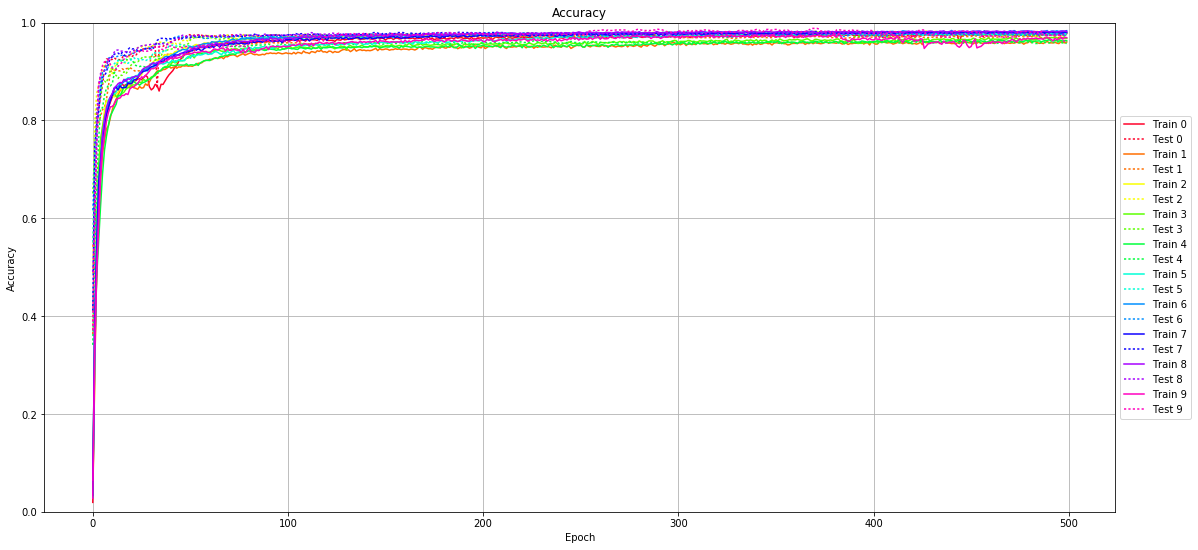

In [18]:
plot_acc(history)

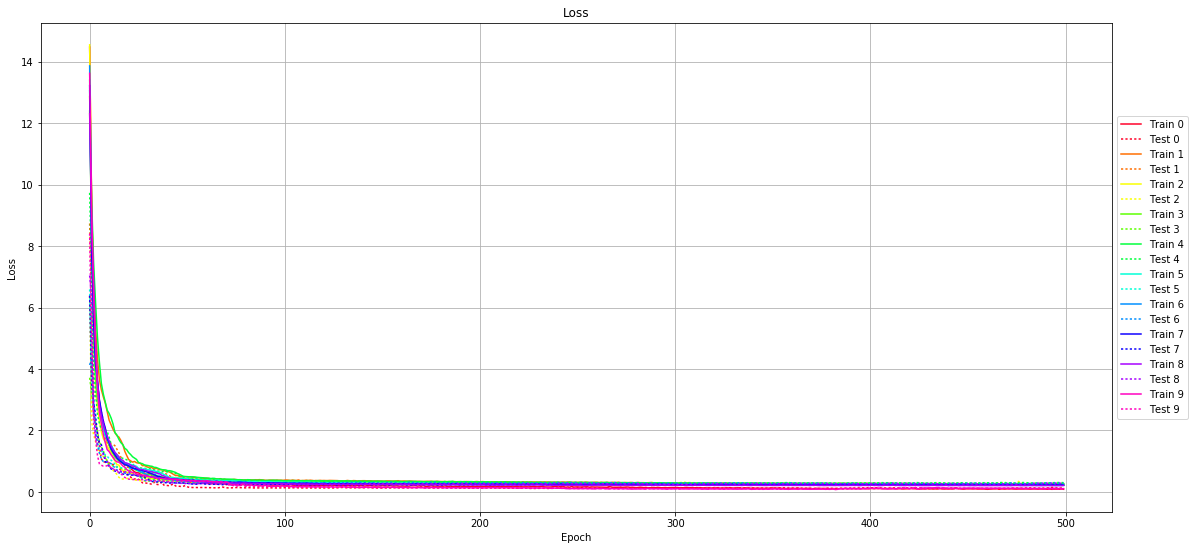

In [19]:
plot_loss(history)

In [22]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


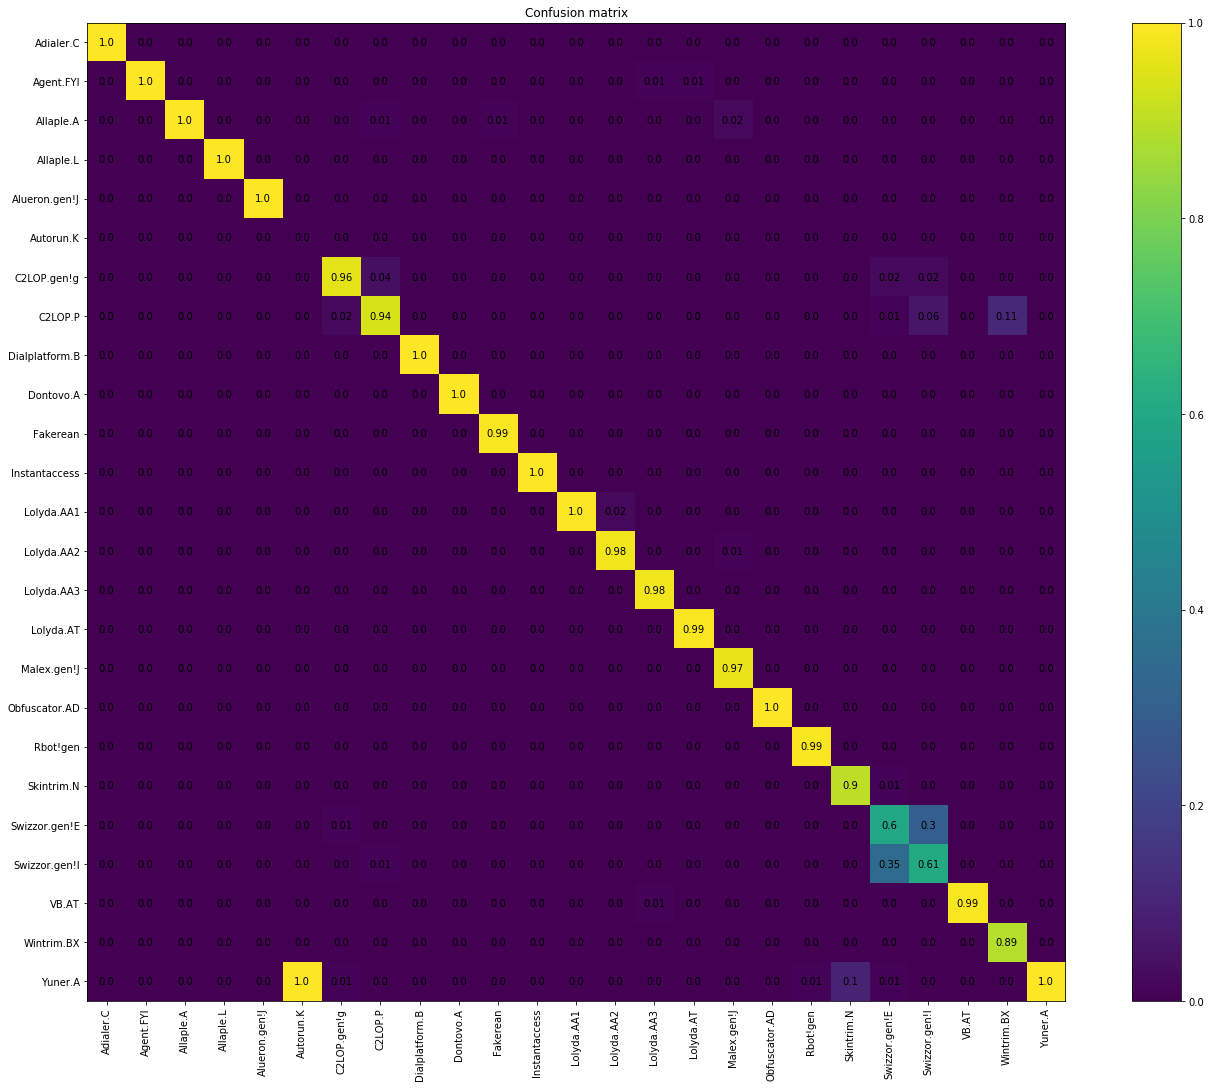

In [23]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()

In [20]:
# Loading the top_model trained in the previous step
top_model = Sequential() 
top_model.add(Flatten(input_shape=base_model.output_shape[1:])) # input_shape=(7,7,512)                                                
top_model.add(Dense(160, activation='relu', name='fc1'))
top_model.add(Dropout(0.4))                
top_model.add(Dense(160, activation='relu', name='fc2'))
top_model.add(Dropout(0.4))              
top_model.add(Dense(num_classes, activation='softmax', name='predictions'))                             
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

top_model.load_weights("top_model-weights-min_loss-mlp-vgg16-2layers-160neurons-relu-0.4dropout-Adam-500epochs.h5")

In [21]:
# Fine-tuning the model (base_model + top_model) 
num_epochs=10
history2 = []
conf_mat2 = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='model-weights-min_loss-mlp-vgg16-2layers-160neurons-relu-0.4dropout-Adam-10epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model = Sequential() 
    model.add(base_model)                                                 
    model.add(top_model)                                                 
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h2 = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=300, verbose=1, callbacks=[checkpointer])
    history2.append(h2)
    
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm2 = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat2 = conf_mat2 + cm2  # Compute global confusion matrix

Train on 8394 samples, validate on 945 samples
Epoch 1/10
8394/8394 [==============================] - 5513s - loss: 15.0970 - acc: 0.0623 - val_loss: 15.8793 - val_acc: 0.0148
Epoch 2/10
8394/8394 [==============================] - 5487s - loss: 15.5459 - acc: 0.0355 - val_loss: 15.8793 - val_acc: 0.0148
Epoch 3/10
8394/8394 [==============================] - 5487s - loss: 15.5209 - acc: 0.0371 - val_loss: 15.8793 - val_acc: 0.0148
Epoch 4/10
8394/8394 [==============================] - 5493s - loss: 15.5017 - acc: 0.0382 - val_loss: 15.8793 - val_acc: 0.0148
Epoch 5/10
8394/8394 [==============================] - 5486s - loss: 15.5862 - acc: 0.0330 - val_loss: 15.8793 - val_acc: 0.0148
Epoch 6/10
8394/8394 [==============================] - 5485s - loss: 15.5267 - acc: 0.0367 - val_loss: 15.8793 - val_acc: 0.0148
Epoch 7/10
8394/8394 [==============================] - 5485s - loss: 15.5113 - acc: 0.0376 - val_loss: 15.8793 - val_acc: 0.0148
Epoch 8/10
8394/8394 [=====================

KeyboardInterrupt: 

In [24]:
# Computing the average accuracy
avg_acc2 = np.trace(conf_mat2)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc2))

Average acurracy: 0.0015


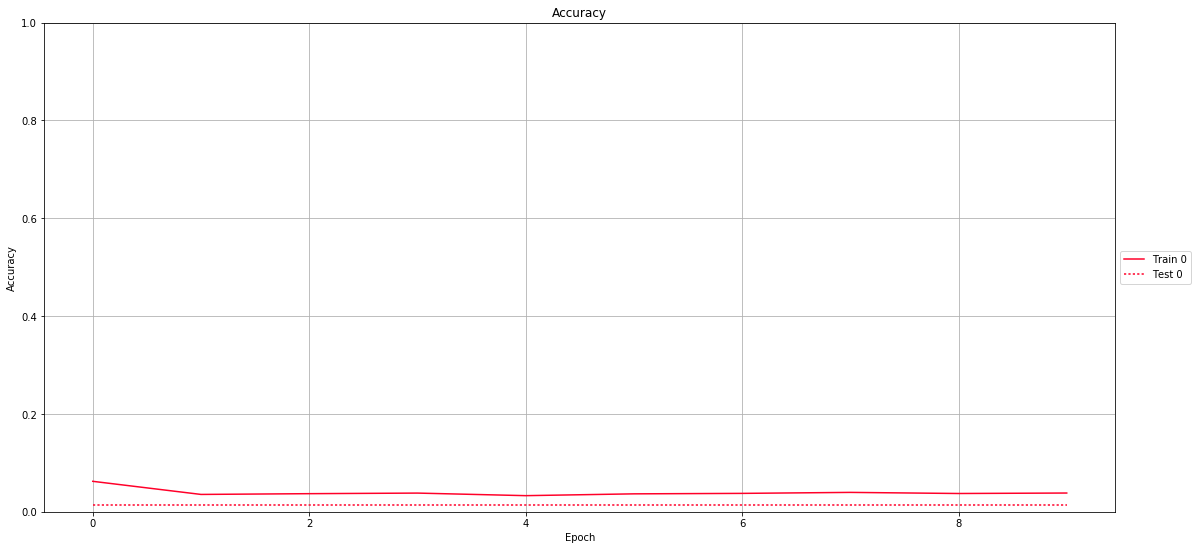

In [25]:
plot_acc(history2)

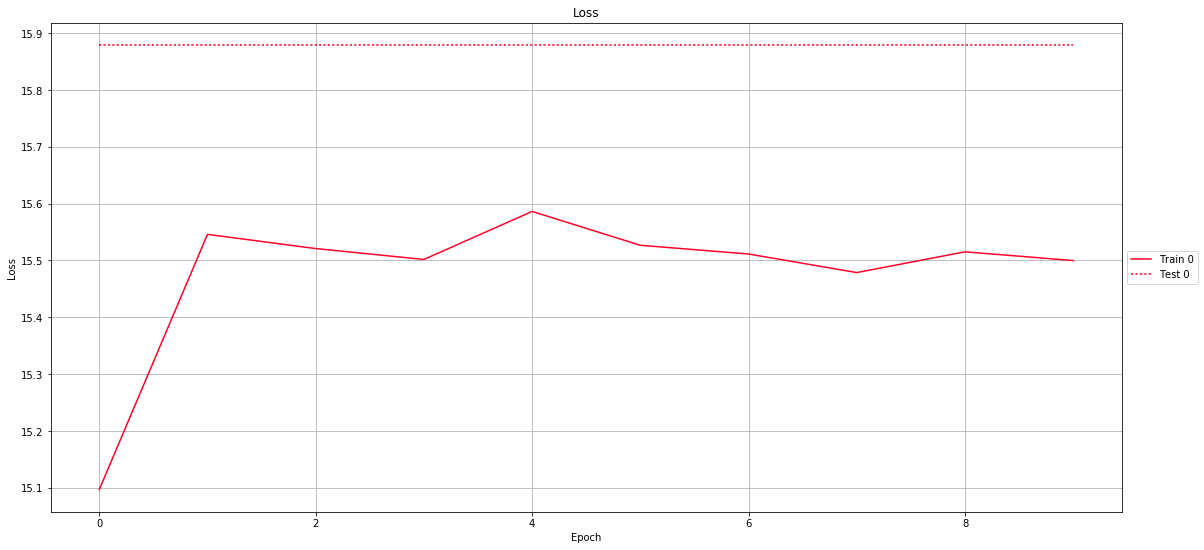

In [26]:
plot_loss(history2)